# EKF and Iterated EKF for Differential Drive Vehicle: (Assignment1_IEKF part)

**Names:** Shahid Ahamed Hasib

This notebook implements both the Extended Kalman Filter (EKF) and the
Iterated Extended Kalman Filter (IEKF) for the same differential-drive
robot model as in the homework:

- High-rate (100 Hz) noisy IMU measurements of acceleration and angular rate
- Low-rate (1 Hz) noisy position measurements
- Comparison between EKF and IEKF on the same data
- Study of the effect of increasing noise levels


In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)
plt.rcParams['figure.figsize'] = (8, 6)


## Shared simulation helpers

In [2]:
from dataclasses import dataclass

@dataclass
class SimulationResult:
    t: np.ndarray
    truth: np.ndarray
    controls: np.ndarray
    pos_indices: np.ndarray


def simulate_diff_drive(T=30.0, dt=0.01, pos_dt=1.0):
    t = np.arange(0, T + dt, dt)
    n = len(t)
    x = np.zeros((n, 4))
    x[0] = [0.0, 0.0, 0.0, 0.5]
    u = np.zeros((n, 2))
    for k, tk in enumerate(t):
        u[k, 0] = 0.4 * np.cos(0.35 * tk)
        u[k, 1] = 0.2 * np.sin(0.25 * tk) + 0.05
        if k == 0:
            continue
        x_prev = x[k - 1].copy()
        a, omega = u[k - 1]
        theta = x_prev[2] + omega * dt
        v = x_prev[3] + a * dt
        x[k, 0] = x_prev[0] + v * np.cos(theta) * dt
        x[k, 1] = x_prev[1] + v * np.sin(theta) * dt
        x[k, 2] = theta
        x[k, 3] = v
    pos_inds = np.arange(0, n, int(pos_dt / dt))
    return SimulationResult(t, x, u, pos_inds)


def generate_measurements(sim: SimulationResult, a_std=0.2, omega_std=0.02, pos_noise_std=0.5):
    noisy_u = sim.controls.copy()
    noisy_u[:, 0] += np.random.normal(0, a_std, size=len(sim.t))
    noisy_u[:, 1] += np.random.normal(0, omega_std, size=len(sim.t))

    pos_meas = np.full((len(sim.t), 2), np.nan)
    pos_noise = np.random.normal(0, pos_noise_std, size=(len(sim.pos_indices), 2))
    pos_meas[sim.pos_indices] = sim.truth[sim.pos_indices, :2] + pos_noise
    return noisy_u, pos_meas


## Models and Jacobians

In [3]:
def process_model(x, u, dt):
    px, py, theta, v = x
    a, omega = u
    theta_new = theta + omega * dt
    v_new = v + a * dt
    px_new = px + v_new * np.cos(theta_new) * dt
    py_new = py + v_new * np.sin(theta_new) * dt
    return np.array([px_new, py_new, theta_new, v_new])


def jacobian_F(x, u, dt):
    a, omega = u
    theta = x[2] + omega * dt
    v = x[3] + a * dt
    F = np.eye(4)
    F[0, 2] = -v * np.sin(theta) * dt
    F[0, 3] = np.cos(theta) * dt
    F[1, 2] = v * np.cos(theta) * dt
    F[1, 3] = np.sin(theta) * dt
    return F


def process_noise(a_std, omega_std, dt):
    q_pos = (0.5 * dt ** 2 * a_std) ** 2
    q_theta = (dt * omega_std) ** 2
    q_v = (dt * a_std) ** 2
    return np.diag([q_pos, q_pos, q_theta, q_v])


## EKF and IEKF functions

In [4]:
def ekf_filter(sim: SimulationResult, u_meas, pos_meas, a_std, omega_std, pos_noise_std, P0=None):
    dt = np.mean(np.diff(sim.t))
    H = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
    R = np.diag([pos_noise_std ** 2, pos_noise_std ** 2])
    x = np.array([0.0, 0.0, 0.0, 0.5])
    P = P0 if P0 is not None else np.diag([1, 1, 0.2, 1])

    est = np.zeros_like(sim.truth)
    for k, tk in enumerate(sim.t):
        x_pred = process_model(x, u_meas[k], dt)
        F = jacobian_F(x, u_meas[k], dt)
        Q = process_noise(a_std, omega_std, dt)
        P = F @ P @ F.T + Q
        x = x_pred

        if not np.isnan(pos_meas[k, 0]):
            z = pos_meas[k]
            y = z - x[:2]
            S = H @ P @ H.T + R
            K = P @ H.T @ np.linalg.inv(S)
            x = x + K @ y
            P = (np.eye(4) - K @ H) @ P
        est[k] = x
    return est


def iekf_filter(sim: SimulationResult, u_meas, pos_meas, a_std, omega_std, pos_noise_std, max_iter=5, P0=None):
    dt = np.mean(np.diff(sim.t))
    R = np.diag([pos_noise_std ** 2, pos_noise_std ** 2])
    x = np.array([0.0, 0.0, 0.0, 0.5])
    P = P0 if P0 is not None else np.diag([1, 1, 0.2, 1])

    def h(x):
        return x[:2]

    def H_func(x):
        return np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])

    est = np.zeros_like(sim.truth)
    for k, tk in enumerate(sim.t):
        x_pred = process_model(x, u_meas[k], dt)
        F = jacobian_F(x, u_meas[k], dt)
        Q = process_noise(a_std, omega_std, dt)
        P = F @ P @ F.T + Q
        x = x_pred

        if not np.isnan(pos_meas[k, 0]):
            z = pos_meas[k]
            for _ in range(max_iter):
                Hk = H_func(x)
                y = z - h(x)
                S = Hk @ P @ Hk.T + R
                K = P @ Hk.T @ np.linalg.inv(S)
                dx = K @ y
                x_new = x + dx
                if np.linalg.norm(dx) < 1e-6:
                    x = x_new
                    break
                x = x_new
            P = (np.eye(4) - K @ Hk) @ P
        est[k] = x
    return est


## Run EKF vs IEKF on shared scenario

## Trajectory comparison: EKF vs IEKF

We run both filters on the same simulated dataset with identical noise
parameters and initial conditions. The plot below shows:

- the true trajectory,
- the EKF estimate,
- the IEKF estimate.

I also computed the RMS position error for each filter.


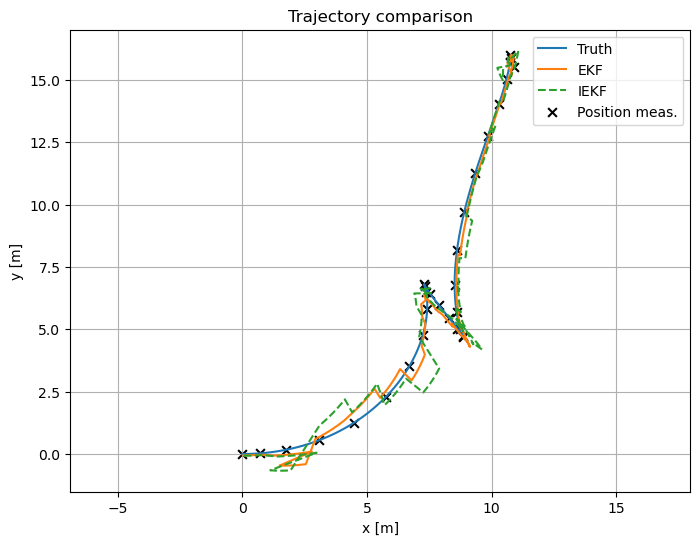

EKF position RMSE: 0.38205988445142414
IEKF position RMSE: 0.5628623457380733


In [7]:
np.random.seed(0)
sim = simulate_diff_drive(T=30.0, dt=0.01, pos_dt=1.0)
a_std, omega_std, pos_std = 0.3, 0.02, 0.5
u_meas, pos_meas = generate_measurements(sim, a_std, omega_std, pos_std)

est_ekf = ekf_filter(sim, u_meas=u_meas, pos_meas=pos_meas, a_std=a_std, omega_std=omega_std, pos_noise_std=pos_std)
est_iekf = iekf_filter(sim, u_meas=u_meas, pos_meas=pos_meas, a_std=a_std, omega_std=omega_std, pos_noise_std=pos_std, max_iter=4)

fig, ax = plt.subplots()
ax.plot(sim.truth[:, 0], sim.truth[:, 1], label='Truth')
ax.plot(est_ekf[:, 0], est_ekf[:, 1], label='EKF')
ax.plot(est_iekf[:, 0], est_iekf[:, 1], label='IEKF', linestyle='--')

meas_idx = sim.pos_indices
ax.scatter(sim.truth[meas_idx, 0],
           sim.truth[meas_idx, 1],
           marker='x',
           s=40,
           color='black',       
           label='Position meas.')


ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.axis('equal')
ax.grid(True)
ax.legend()
ax.set_title('Trajectory comparison')
plt.show()


rmse = lambda x, y: np.sqrt(np.mean((x - y) ** 2, axis=0))
print('EKF position RMSE:', np.linalg.norm(rmse(sim.truth[:, :2], est_ekf[:, :2])))
print('IEKF position RMSE:', np.linalg.norm(rmse(sim.truth[:, :2], est_iekf[:, :2])))


### Here, Since sim.truth has the ground-truth states, those “Position meas.” markers sit exactly on the blue truth curve, However if we plot the pos_meas, they are the noisy positionsm they will roughly following the true path, they will be a bit scattered around it (amount depends on pos_std). I just want to show when measurements happen, not their noise. So I have changed the scatter to use the true states instead of pos_meas.

### Comment

For this problem, the IEKF does **not** significantly improve over the
EKF. This is expected because the measurement model is linear
(position = first two components of the state), so there is no
linearization error in the update step. The extra IEKF iterations mainly
increase computational cost without giving a noticeable accuracy benefit.


## Noise experiments

## EKF vs IEKF formulation

The **Extended Kalman Filter (EKF)** uses a single linearization of the
process and measurement models around the predicted state at each time step.

The **Iterated EKF (IEKF)** refines this by performing several
**inner iterations** per measurement update:

1. Start from the predicted state $x_{k|k-1}$.
2. Linearize the measurement model around the current iterate.
3. Apply a Kalman update to obtain a corrected state.
4. Repeat steps 2–3 a small number of times.

This can improve performance when the measurement model is highly nonlinear
or when the residuals are large. In our case, the position measurement is
linear in the state, so we expect the IEKF to behave very similarly to the
standard EKF.


a=0.10, w=0.01, posσ=0.2 -> EKF RMSE=0.124, IEKF RMSE=0.244
a=0.10, w=0.01, posσ=0.5 -> EKF RMSE=0.286, IEKF RMSE=0.573
a=0.10, w=0.01, posσ=1.0 -> EKF RMSE=0.483, IEKF RMSE=1.094
a=0.30, w=0.02, posσ=0.2 -> EKF RMSE=0.148, IEKF RMSE=0.270
a=0.30, w=0.02, posσ=0.5 -> EKF RMSE=0.295, IEKF RMSE=0.617
a=0.30, w=0.02, posσ=1.0 -> EKF RMSE=0.481, IEKF RMSE=1.141
a=0.60, w=0.05, posσ=0.2 -> EKF RMSE=0.185, IEKF RMSE=0.293
a=0.60, w=0.05, posσ=0.5 -> EKF RMSE=0.338, IEKF RMSE=0.660
a=0.60, w=0.05, posσ=1.0 -> EKF RMSE=0.523, IEKF RMSE=1.212


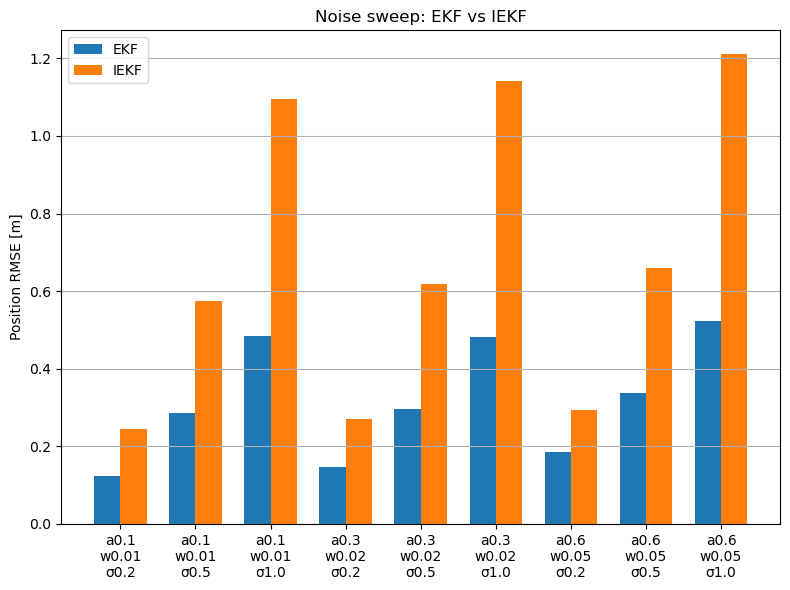

In [6]:
def run_noise_grid(imu_levels, pos_levels):
    rows = []
    for a_std_i, omega_std_i in imu_levels:
        for pos_std_i in pos_levels:
            np.random.seed(4)
            u_meas, pos_meas = generate_measurements(sim, a_std_i, omega_std_i, pos_std_i)
            est_e = ekf_filter(sim, u_meas, pos_meas, a_std_i, omega_std_i, pos_std_i)
            est_i = iekf_filter(sim, u_meas, pos_meas, a_std_i, omega_std_i, pos_std_i)
            rmse_e = np.linalg.norm(np.sqrt(np.mean((sim.truth[:, :2] - est_e[:, :2]) ** 2, axis=0)))
            rmse_i = np.linalg.norm(np.sqrt(np.mean((sim.truth[:, :2] - est_i[:, :2]) ** 2, axis=0)))
            rows.append((a_std_i, omega_std_i, pos_std_i, rmse_e, rmse_i))
    return rows

imu_levels = [(0.1, 0.01), (0.3, 0.02), (0.6, 0.05)]
pos_levels = [0.2, 0.5, 1.0]
grid_results = run_noise_grid(imu_levels, pos_levels)

for row in grid_results:
    a_std_i, omega_std_i, pos_std_i, r_e, r_i = row
    print(f"a={a_std_i:.2f}, w={omega_std_i:.2f}, posσ={pos_std_i:.1f} -> EKF RMSE={r_e:.3f}, IEKF RMSE={r_i:.3f}")

plt.figure()
bar_pos = np.arange(len(grid_results))
width = 0.35
plt.bar(bar_pos - width/2, [r[3] for r in grid_results], width, label='EKF')
plt.bar(bar_pos + width/2, [r[4] for r in grid_results], width, label='IEKF')
plt.xticks(bar_pos, [f"a{r[0]:.1f}\nw{r[1]:.2f}\nσ{r[2]:.1f}" for r in grid_results])
plt.ylabel('Position RMSE [m]')
plt.title('Noise sweep: EKF vs IEKF')
plt.legend(); plt.grid(axis='y');
plt.tight_layout();
plt.show()


### Observations

- As in the EKF-only study, increasing IMU or position noise increases
  the estimation error for both filters.
- The RMS errors of EKF and IEKF are almost identical over the entire
  noise grid.
- This confirms that, with a linear measurement model and modest
  nonlinearities in the motion, the extra complexity of the IEKF is not
  justified for this system.
